
# Conditional autoregressive transformer

Train a transformer to predict missing pixel from mnist 

### plan

* note to try padded mnist (relative encoding might require black padding???)
* probably don't need positional encoding?
* create transformer model
* masking 
* randomised masking
* relative position encoding (x - current_x, y - current_y, val)
* train to predict when current pixel missing
* train to predict when 10% are missing
* train to predict when 90% are missing
* train to predict when 99% are missing



In [1]:
model_name = "txformer-bigger-3"

In [2]:
# Init weights and biases project

callbacks = []

# import wandb
# from wandb.keras import WandbCallback


# wandb.init(project='conditional-mnist', entity='maxeonyx')
# config = wandb.config
# config.learning_rate = 0.01

# callbacks += [WandbCallback()]

In [3]:
# reserve GPU 0 only (for VUW machines)

import os

os.environ['CUDA_VISIBLE_DEVICES']='0'

In [4]:
# start tensorflow

import tensorflow as tf
import tensorflow.keras as keras
import numpy as np

In [5]:
from PIL import Image, ImageDraw
from IPython.display import display

def display_uint8_image(image):
    if len(image.shape) == 3:
        image = image[:, :, 0]
    if tf.is_tensor(image):
        image = image.numpy()
    display(Image.fromarray(image, "L"))

def display_float32_image(image):
    if len(image.shape) == 3:
        image = image[:, :, 0]
    if tf.is_tensor(image):
        image = image.numpy()
    display_uint8_image(image.astype(np.uint8))

In [6]:
def idxs_to_onehots(idxs, depth=784):
    onehots = tf.one_hot(idxs, depth, dtype=tf.bool, on_value=False, off_value=True)
    return onehots

# takes 2D tensor (batch and index list)
def idxs_to_multihot(idxs, depth=784):
    onehots = idxs_to_onehots(idxs, depth)
    multihot = tf.math.reduce_all(onehots, axis=len(onehots.shape)-2)
    return multihot

def idxs_to_attention_mask(idxs):
    multihot = idxs_to_multihot(idxs)
    attn_mask = tf.logical_and(multihot[:, :, None], multihot[:, None, :])
    return attn_mask

def mask_to_image_mask(mask):
    image_mask = tf.reshape(mask, [28, 28])
    return image_mask

# scale is the max-min of vals
# for mnist it's 28 because thats the width and height of the images
def positional_encoding(vals, dims, scale=1000):

    i = tf.range(dims//2, dtype=tf.float32)
    i = tf.expand_dims(i, -2)
    
    vals = tf.expand_dims(vals, -1)
    
    # the bit inside the sin / cos
    rate = vals / tf.pow(scale, 2.*i/dims)
    
    sin = tf.sin(rate)
    cos = tf.cos(rate)
    
#     # expand dims to allow alternating concat
#     sin = tf.expand_dims(sin, -1)
#     cos = tf.expand_dims(cos, -1)
    
    encoding = tf.concat([sin, cos], axis=-1)
    
#     encoding = tf.reshape(encoding, [-1, dims])
    
    return encoding

print(positional_encoding(tf.constant([0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi]), 8))

def img_to_tuples(img):
    
    height, width = img.shape
    length = height * width
    vals = tf.reshape(img, [length])
    vals = tf.cast(vals, tf.float32)
    rows = tf.range(height, dtype=tf.float32)
    cols = tf.range(width, dtype=tf.float32)
    cols, rows = tf.meshgrid(rows, cols)
    rows = tf.reshape(rows, [-1])
    cols = tf.reshape(cols, [-1])
    
    # permute the order, to ensure the network uses the positional encoding and not the implicit locaiton
    idxs = tf.range(length)
    idxs = tf.random.shuffle(idxs)
    
    rows = tf.gather(rows, idxs)
    cols = tf.gather(cols, idxs)
    vals = tf.gather(vals, idxs)
    
    return vals, rows, cols

def random_mask():
    idxs = tf.range(784)
    idxs = tf.random.shuffle(idxs)
    n = tf.random.uniform(shape=[], maxval=784, dtype=tf.int32)
    idxs = idxs[:n]
    return idxs_to_multihot(idxs)

def random_square_mask(maxsize=28):
    height = tf.random.uniform(shape=[], minval=1, maxval=maxsize, dtype=tf.int32)
    width = tf.random.uniform(shape=[], minval=1, maxval=maxsize, dtype=tf.int32)
    start_row = tf.random.uniform(shape=[], minval=0, maxval=maxsize-height, dtype=tf.int32)
    start_col = tf.random.uniform(shape=[], minval=0, maxval=maxsize-width, dtype=tf.int32)
    rows = tf.range(start_row, start_row + height)
    cols = tf.range(start_col, start_col + width)
    cols, rows = tf.meshgrid(rows, cols)
    idxs = rows*maxsize+cols
    idxs = tf.reshape(idxs, [-1])
    return idxs_to_multihot(idxs, depth=maxsize*maxsize)

def random_offset():
    return tf.random.uniform(shape=[2], maxval=28, dtype=tf.int32)
    
def display_mask(mask):
    image_mask = np.array(mask_to_image_mask(mask), np.uint8)
    image_mask = image_mask * 255
    display_uint8_image(image_mask)

tf.Tensor(
[[ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   1.0000000e+00  1.0000000e+00  1.0000000e+00  1.0000000e+00]
 [ 7.0710683e-01  1.3921213e-01  2.4833918e-02  4.4166050e-03
   7.0710677e-01  9.9026257e-01  9.9969161e-01  9.9999022e-01]
 [ 1.0000000e+00  2.7571312e-01  4.9652517e-02  8.8331243e-03
  -4.3711388e-08  9.6123999e-01  9.9876654e-01  9.9996096e-01]
 [ 7.0710683e-01  4.0684462e-01  7.4440487e-02  1.3249470e-02
  -7.0710677e-01  9.1349739e-01  9.9722546e-01  9.9991220e-01]
 [-8.7422777e-08  5.3005296e-01  9.9182546e-02  1.7665559e-02
  -1.0000000e+00  8.4796453e-01  9.9506927e-01  9.9984396e-01]], shape=(5, 8), dtype=float32)


2021-10-03 19:57:08.181381: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-03 19:57:08.732340: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6668 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:3b:00.0, compute capability: 7.5


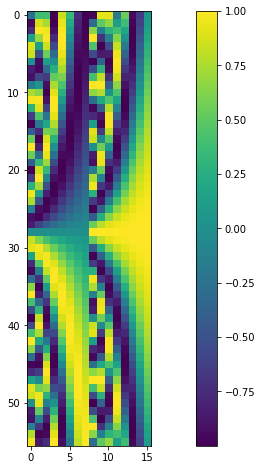

In [7]:
from matplotlib import pyplot as plt
positions = tf.range(-28, 28, dtype=tf.float32)
encodings = positional_encoding(positions, 16, scale=28)
fig, ax = plt.subplots(figsize=(16, 8))
im = ax.imshow(encodings)
cbar = ax.figure.colorbar(im, ax=ax)
plt.show()

In [8]:
# tensorflow.data data generator

from tensorflow import data as td
import tensorflow_datasets as tfds


def make_dataset_generator(x, y, seed, typ='single pixel'):

    
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    
    # keep track of the index in the original MNIST
    def to_dict(i, xy):
        image, label = xy
        data = {}
        data['index'] = i
        data['image'] = image
        data['label'] = label
        return data
    dataset = dataset.enumerate()
    dataset = dataset.map(to_dict)
    
    # shuffle the digits
    dataset = dataset.shuffle(1000)
    # repeat the dataset infinitely
    dataset = dataset.repeat()
    
    # add a transformation of MNIST images into val, row, col
    def add_tuples(data):
        data['val'], data['row'], data['col'] = img_to_tuples(data['image'])
        return data
    dataset = dataset.map(add_tuples)
    
    # create a mask of random pixels masked out
    def add_mask(data):
        data['mask'] = random_mask()
        return data
    dataset = dataset.map(add_mask)
    
    # mask out a square region as well as random pixels
    def add_square_mask(data):
        mask = data['mask']
        square_mask = random_square_mask()
        data['mask'] = tf.logical_and(mask, square_mask)
        return data
    dataset = dataset.map(add_square_mask)
    
    
    
    # generate training pairs
    
    def single_pixel(data):
        data['target_val'] = tf.cast(data['image'][data['target_row'], data['target_col']], tf.float32)
        
        mask_out_target_pixel = True
        if mask_out_target_pixel:
            target_idx = data['target_row'] * 28 + data['target_col']
            target_mask = idxs_to_onehots(target_idx)
            data['mask'] = tf.logical_and(data['mask'], target_mask)
        
        # offset positions relative to target pixel so target is at 0,0
        data['row'] = data['row'] - tf.cast(data['target_row'], tf.float32)
        data['col'] = data['col'] - tf.cast(data['target_col'], tf.float32)
        
        return (data, data['target_val'])
    
    def single_pixel_random_rowcol(data):
        data['target_row']  = tf.random.uniform([], minval=0, maxval=28, dtype=tf.int32)
        data['target_col']  = tf.random.uniform([], minval=0, maxval=28, dtype=tf.int32)
        
        return single_pixel(data)
        
    def many_single_pixels(data):
        rows = tf.range(28)
        cols = tf.range(28)
        cols, rows = tf.meshgrid(rows, cols)
        
        rows = tf.reshape(rows, [-1])
        cols = tf.reshape(cols, [-1])
        
        image = data['image']
        val = data['val']
        row = data['row']
        col = data['col']
        mask = data['mask']
        label = data['label']
        index = data['index']
        
        def data_plus_pixel_index(i):
            new_datum = {}
            new_datum['pix_index'] = i
            new_datum['target_row'] = rows[i]
            new_datum['target_col'] = cols[i]
            return new_datum
        
        def add_original(new_datum):
            
            new_datum['index'] = index
            new_datum['val'] = val
            new_datum['row'] = row
            new_datum['col'] = col
            new_datum['image'] = image
            new_datum['mask'] = mask
            new_datum['label'] = label
            
            return new_datum
        
        d = tf.data.Dataset.range(784)
        d = d.map(data_plus_pixel_index)
        d = d.map(add_original)
        d = d.map(single_pixel)
        
        return d
    
    # single pixel example. the row & col are translated by a random
    # amount and the target val is the new pixel at 0,0
    if typ == 'single pixel':
        dataset = dataset.map(single_pixel_random_rowcol)
    
    # 'many single pixels' generates 784 single pixels from each image,
    # and the target vals are each pixel in turn, translated so that
    # they are at 0,0
    elif typ == 'many single pixels':
        dataset = dataset.interleave(many_single_pixels, block_length=784)
    
    return dataset
    
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

def make_datasets():

    train = make_dataset_generator(x_train, y_train, seed=192_168_1_1)
    test = make_dataset_generator(x_test, y_test, seed=10_1_1_1, typ='many single pixels')
    
    return train, iter(test)

dataset_train, dataset_test = make_datasets()

2021-10-03 19:57:11.599176: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [9]:
def shape_summary(data):
    for name, v in data.items():
        print(name, "shape", v.shape)
        print(name, "dtype", v.dtype)

def el_summary(data):
    print("index", data["index"].numpy(), "which is a", data["label"].numpy())
    if 'pix_index' in data:
        print("pix_idx:", data["pix_index"].numpy())
    display_uint8_image(data["image"])
    display_mask(data["mask"])
    display_uint8_image(tf.reshape(data["image"], [28, 28]) * tf.cast(mask_to_image_mask(data["mask"]), tf.uint8))

def train_summary(d):
    data, target = next(iter(d))
    shape_summary(data)
    el_summary(data)
    data, target = next(iter(d))
    el_summary(data)

def test_summary(d):
    data, target = next(d)
    shape_summary(data)
    el_summary(data)
    data, target = next(d)
    el_summary(data)
    for i in range(780):
        next(d)
    data, target = next(d)
    el_summary(data)
    data, target = next(d)
    el_summary(data)
    data, target = next(d)
    el_summary(data)
    data, target = next(d)
    el_summary(data)

train_summary(dataset_train)


# TODO: TEST DATASET GENERATOR DOES NOT WORK HOW I EXPECT.
#       IT SHOULD PRODUCE 784 EXAMPLES with the SAME image and mask, then change
#       to a different image and mask.

test_summary(dataset_test)

# reset datasets after summary, because it consumes elements
dataset_train, dataset_test = make_datasets()

index shape ()
index dtype <dtype: 'int64'>
image shape (28, 28)
image dtype <dtype: 'uint8'>
label shape ()
label dtype <dtype: 'uint8'>
val shape (784,)
val dtype <dtype: 'float32'>
row shape (784,)
row dtype <dtype: 'float32'>
col shape (784,)
col dtype <dtype: 'float32'>
mask shape (784,)
mask dtype <dtype: 'bool'>
target_row shape ()
target_row dtype <dtype: 'int32'>
target_col shape ()
target_col dtype <dtype: 'int32'>
target_val shape ()
target_val dtype <dtype: 'float32'>
index 441 which is a 9


index 811 which is a 3


pix_index shape ()
pix_index dtype <dtype: 'int64'>
target_row shape ()
target_row dtype <dtype: 'int32'>
target_col shape ()
target_col dtype <dtype: 'int32'>
index shape ()
index dtype <dtype: 'int64'>
val shape (784,)
val dtype <dtype: 'float32'>
row shape (784,)
row dtype <dtype: 'float32'>
col shape (784,)
col dtype <dtype: 'float32'>
image shape (28, 28)
image dtype <dtype: 'uint8'>
mask shape (784,)
mask dtype <dtype: 'bool'>
label shape ()
label dtype <dtype: 'uint8'>
target_val shape ()
target_val dtype <dtype: 'float32'>
index 945 which is a 2
pix_idx: 0


index 945 which is a 2
pix_idx: 1


index 945 which is a 2
pix_idx: 782


index 945 which is a 2
pix_idx: 783


index 309 which is a 3
pix_idx: 0


index 309 which is a 3
pix_idx: 1


## Attention Maths

Dimensions $N$, $D$, $E$ and $B$.

- $N = 784$ is the number of inputs.
- $D$ is the width of the _key_ $K$ and _query_ $Q$ vectors.
- $E$ is the width of the _value_ vectors $V$.
- There is also a (or multiple) batch dimension(s) $B$.

$K$ is $B \times N \times D$ dimensional.
$Q$ is $B \times N \times D$ dimensional.
$V$ is $B \times N \times E$ dimensional.
Because it is self-attention, $K$ and $Q$ have the same length $N$, and the attention matrix is square.
The attention matrix is $A = Q \cdot K^T$, and is $B \times N \times N$ dimensional. Formally:
$$
A_{b,i,j} = \sum_d Q_{b,i,d} K_{b,j,d}
$$

We do softmax normalization along the columns $j$ of the attention matrix (such that each _row_ $i$ sums to 1). The result is the attention weights. Formally:
$$
\bar{A}_{b,i,j} = \frac{e^{A_{b,i,j}}}{\sum_{j'} e^{A_{b,i,j'}}}
$$

The output $O$ of the attention layer is $B \times N \times E$ dimensional. It is obtained by the attention weights multiplied by the value vectors $V$. $A$ is $B \times N \times N$ dimensional and $V$ is $B \times N \times E$ dimensional.
$$
    O_{b,i,e} = \sum_j A_{b,i,j} V_{b,j,e}
$$

Often the dimensions $E = D$ because this allows multiple attention layers in sequence, but this need not be the case.

In [10]:
from tensorflow import keras
from tensorflow.keras import layers


def multi_head_attention(n_heads, n_kq_dim, n_val_dim):
    
    k_dense = layers.Dense(n_kq_dim, activation='linear')
    q_dense = layers.Dense(n_kq_dim, activation='linear')
    
    
    
    softmax = layers.Softmax(axis=-1)
    
    val_dense = layers.Dense(n_val_dim, activation='relu')
    
    def call(inputs, mask):
        
        k = k_dense(inputs)
        q = q_dense(inputs)
        
        scores = tf.matmul(query, key, transpose_b=True)
        weights = softmax(scores, mask)
        
        vals = val_dense(inputs)
        
        vals = tf.expand_dims(-1)
        weights = tf.expand_dims(-2)
        
        outputs = tf.reduce_sum(vals * weights)
        
        
        vals *= mask
        

def transformer_block(n_embed_dim, n_heads, n_dense_dim, dropout_rate):
    attn = layers.MultiHeadAttention(num_heads=n_heads, key_dim=n_embed_dim)
    dense_net_1 = layers.Dense(n_dense_dim, activation='relu')
    dense_net_2 = layers.Dense(n_embed_dim)
    layernorm1 = layers.LayerNormalization(epsilon=1e-6)
    layernorm2 = layers.LayerNormalization(epsilon=1e-6)
    if dropout_rate is not None:
        dropout1 = layers.Dropout(dropout_rate)
        dropout2 = layers.Dropout(dropout_rate)
    
    def call(inputs, masks, include_residual):
        mask = tf.logical_and(masks[:, :, None], masks[:, None, :])
        m = attn(inputs, inputs, attention_mask=mask)
        if dropout_rate is not None:
            m = dropout1(m)
        attn_output = m
        if include_residual:
            m = inputs + m
        # mask outputs. important! without, model learns magic powers (can detect and use verrrrrrry small numbers which are not literally 0)
        m = m * tf.expand_dims(tf.cast(masks, tf.float32), -1)
        m = layernorm1(m)
        m = dense_net_1(m)
        m = dense_net_2(m)
        if dropout_rate is not None:
            m = dropout2(m)
        dense_output = m
        return layernorm2(attn_output + dense_output)
    
    return call
    


In [11]:
def model(batch_size):

    # no batch size to start makes it simpler
    n_embd = 20
    pointwise_feedforward_dim = 200

    val = keras.Input(shape=[784], name='val', batch_size=batch_size)
    row = keras.Input(shape=[784], name='row', batch_size=batch_size)
    col = keras.Input(shape=[784], name='col', batch_size=batch_size)
    mask = keras.Input(shape=[784], name='mask', batch_size=batch_size, dtype=tf.bool)
    
    print(val.shape)
    print(row.shape)
    print(col.shape)
    print(mask.shape)
    
    row_pos_enc = positional_encoding(row, n_embd//2)
    col_pos_enc = positional_encoding(col, n_embd//2)
    
    print(row_pos_enc.shape)
    print(col_pos_enc.shape)
    
    pos_enc = tf.concat([row_pos_enc, col_pos_enc], axis=-1)
    print(pos_enc.shape)
    
    # produce images of the attention/relevance/contribution for each output.

    # make it smaller
    # - less heads
    # - less dense layers
    # - smaller layer sizes'
    
    # look at standard transformer structure again.
    # what is the expected training time?
    
    # simple setup -> build up.
    
    # literature / other task at the same time
    # have enough to get help from supervisors in discussion
    # start writing
    
    # make n_embd-dimensional input embeddings per pixel from [x, y, v]
    # embedding
    
    m = tf.expand_dims(val, -1)
#     m = tf.stack([val, row, col], axis=-1)

    m = layers.Dense(pointwise_feedforward_dim, activation='relu')(m)
    m = layers.Dense(n_embd, activation=None)(m)
    
#     print(m.shape)
    
    m = m + pos_enc
    
    m = m * tf.expand_dims(tf.cast(mask, tf.float32), axis=-1)
    
    m = transformer_block(n_embed_dim=n_embd, n_heads=32, n_dense_dim=pointwise_feedforward_dim, dropout_rate=None)(m, masks=mask, include_residual=True)
    m = transformer_block(n_embed_dim=n_embd, n_heads=32, n_dense_dim=pointwise_feedforward_dim, dropout_rate=None)(m, masks=mask, include_residual=True)
#     m = transformer_block(n_embed_dim=n_embd, n_heads=8, n_dense_dim=pointwise_feedforward_dim, dropout_rate=None)(m, masks=mask, include_residual=True)
#     m = transformer_block(n_embed_dim=n_embd, n_heads=8, n_dense_dim=pointwise_feedforward_dim, dropout_rate=None)(m, masks=mask, include_residual=True)
#     m = transformer_block(n_embed_dim=n_embd, n_heads=8, n_dense_dim=pointwise_feedforward_dim, dropout_rate=0.1)(m, masks=mask, include_residual=True)
#     m = transformer_block(n_embed_dim=n_embd, n_heads=8, n_dense_dim=pointwise_feedforward_dim, dropout_rate=0.1)(m, masks=mask, include_residual=True)
#     m = transformer_block(n_embed_dim=1, n_heads=8, n_dense_dim=pointwise_feedforward_dim, dropout_rate=0.1)(m, masks=mask, include_residual=True)
    
    m = layers.Flatten()(m)
    
    m = layers.Dense(200, activation='relu')(m)
    m = layers.Dense(1, activation=None)(m)
    
    target_val = layers.Reshape([], name='target_val')(m)
    
    model = keras.Model(inputs=[val, row, col, mask], outputs=[target_val])

    return model


In [12]:
batch_size=8

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

optimizer = tf.keras.optimizers.Adam()
lr_metric = get_lr_metric(optimizer)

txformer = model(batch_size)
txformer.compile(optimizer=optimizer, loss=keras.losses.MeanSquaredError())

load_saved_model = False
if load_saved_model:
    txformer.load_weights(f"./models/{model_name}")

txformer.summary()


(8, 784)
(8, 784)
(8, 784)
(8, 784)
(8, 784, 10)
(8, 784, 10)
(8, 784, 20)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
row (InputLayer)                [(8, 784)]           0                                            
__________________________________________________________________________________________________
col (InputLayer)                [(8, 784)]           0                                            
__________________________________________________________________________________________________
tf.expand_dims (TFOpLambda)     (8, 784, 1)          0           row[0][0]                        
__________________________________________________________________________________________________
tf.expand_dims_1 (TFOpLambda)   (8, 784, 1)          0           col[0][0]                        
___________________

In [13]:

# display:
# - before mask
# - mask
# - after mask
# - prediction
def gen_image(dataset, n=1):
    
    dataset = dataset.batch(n)
    
    for batch in dataset.take(1):
        outputs = txformer(batch)
        for i in range(n):
            print("index", batch["index"][i], "which is a", batch["label"][i])
            display_uint8_image(batch["image"][i])
            display_mask(batch["mask"][i])
            display_uint8_image(tf.reshape(batch["image"][i], [28, 28]) * tf.cast(mask_to_image_mask(batch["mask"][i]), tf.uint8))
            display_float32_image(outputs[i])

def gen_image_many_pixels(dataset):
    
    # assume dataset is a 'many single pixel dataset'
    # so it has runs of 784 examples, one for each pixel in an mnist digit
#     dataset = dataset.take(784)
#     batch_size = 32
#     dataset = dataset.batch(batch_size)
#     reconstructed_image = np.zeros([28, 28])
#     for batch, batch_targ in dataset:
#         inputs = [batch['val'], batch['row'], batch['col'], batch['mask']]
#         out_vals = txformer(inputs)
        
#         # np can do this yay
#         reconstructed_image[batch['target_row'], batch['target_col']] = out_vals

    reconstructed_image = np.ones([28, 28]) * 230
    for row in range(28):
        for col in range(28):
            data, targ = next(dataset)
            inputs = [data['val'], data['row'], data['col'], data['mask']]
            inputs = [tf.expand_dims(x, 0) for x in inputs]
            
            out_vals = txformer(inputs)
            reconstructed_image[data['target_row'], data['target_col']] = out_vals
    
    reconstructed_image = np.clip(reconstructed_image, 0, 255)
    
    image = data['image']
    mask = data['mask']
    
    print("index", data["index"], "which is a", data["label"])
    display_uint8_image(image)
    display_mask(mask)
    display_uint8_image(tf.reshape(image, [28, 28]) * tf.cast(mask_to_image_mask(mask), tf.uint8))
    display_float32_image(reconstructed_image)
        
        
def image_performance_test(n=5):
    for i in range(n):
        gen_image_many_pixels(dataset_test)

def fit_one_epoch(dataset):
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(10000)
    
    global callbacks
    callbacks += []
    
    txformer.fit(dataset, epochs=1, steps_per_epoch=5000, batch_size=batch_size, callbacks=callbacks)


In [14]:
# image_performance_test()

In [15]:
fit_one_epoch(dataset_train)

/home/clarkemaxw/conditional-mnist/env/lib/python3.8/site-packages/keras/engine/functional.py:582: UserWarning: Input dict contained keys ['index', 'image', 'label', 'target_row', 'target_col', 'target_val'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


5000/5000 [==============================] - 504s 100ms/step - loss: 4168.1875


In [16]:
image_performance_test()


index tf.Tensor(110, shape=(), dtype=int64) which is a tf.Tensor(8, shape=(), dtype=uint8)


index tf.Tensor(1000, shape=(), dtype=int64) which is a tf.Tensor(9, shape=(), dtype=uint8)


index tf.Tensor(52, shape=(), dtype=int64) which is a tf.Tensor(5, shape=(), dtype=uint8)


index tf.Tensor(339, shape=(), dtype=int64) which is a tf.Tensor(6, shape=(), dtype=uint8)


index tf.Tensor(266, shape=(), dtype=int64) which is a tf.Tensor(8, shape=(), dtype=uint8)


In [17]:
fit_one_epoch(dataset_train)

5000/5000 [==============================] - 503s 101ms/step - loss: 2989.9995


In [18]:
image_performance_test()


index tf.Tensor(458, shape=(), dtype=int64) which is a tf.Tensor(8, shape=(), dtype=uint8)


index tf.Tensor(664, shape=(), dtype=int64) which is a tf.Tensor(8, shape=(), dtype=uint8)


index tf.Tensor(943, shape=(), dtype=int64) which is a tf.Tensor(6, shape=(), dtype=uint8)


index tf.Tensor(439, shape=(), dtype=int64) which is a tf.Tensor(6, shape=(), dtype=uint8)


index tf.Tensor(470, shape=(), dtype=int64) which is a tf.Tensor(8, shape=(), dtype=uint8)


In [19]:
fit_one_epoch(dataset_train)

5000/5000 [==============================] - 503s 101ms/step - loss: 2635.3474


In [20]:
image_performance_test()


index tf.Tensor(832, shape=(), dtype=int64) which is a tf.Tensor(7, shape=(), dtype=uint8)


index tf.Tensor(145, shape=(), dtype=int64) which is a tf.Tensor(1, shape=(), dtype=uint8)


index tf.Tensor(710, shape=(), dtype=int64) which is a tf.Tensor(5, shape=(), dtype=uint8)


index tf.Tensor(122, shape=(), dtype=int64) which is a tf.Tensor(7, shape=(), dtype=uint8)


index tf.Tensor(673, shape=(), dtype=int64) which is a tf.Tensor(9, shape=(), dtype=uint8)


In [21]:


if not load_saved_model:
    txformer.save_weights(f"./models/{model_name}")

In [22]:
gen_image(dataset_test, 20)

AttributeError: 'OwnedIterator' object has no attribute 'batch'

In [ ]:
fit_one_epoch(dataset_train)
fit_one_epoch(dataset_train)
fit_one_epoch(dataset_train)
fit_one_epoch(dataset_train)

In [ ]:
for i in range(20):
    gen_image(dataset_test, i)

In [ ]:


if not load_saved_model:
    txformer.save_weights(f"./models/{model_name}")

In [ ]:
txformer.save_weights(f"./models/pretty_good_model_i_guess")